<hr> Jujuuuls Vision Transformers

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader

import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import trange, tqdm

In [2]:
torch.set_float32_matmul_precision('medium')  # or 'medium' for even more speed

In [3]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("PyTorch Version:", torch.__version__)
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
PyTorch Version: 2.5.1
Device: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [ ]:
# The size of our mini batches
batch_size = 1 #1

# How many itterations of our dataset
num_epochs = 50 #50

# Optimizer learning rate
learning_rate = 1e-4

# Where to load/save the dataset from 
train_dir = "C:/Users/Ju/Downloads/weld_vit_split/train"
test_dir = "C:/Users/Ju/Downloads/weld_vit_split/test"


# The size of each patch in the sequence
# Our images are quite small so we'll use a smaller image patch size
patch_size = 4 # 4

In [5]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 1
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

In [6]:
import torch
import torchvision.models as models

# Initialize the model (for example, a pre-trained ResNet)
model = models.resnet18(pretrained=True)

# Move the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check where the model's parameters are located
print("Model is on:", next(model.parameters()).device)  # Should print 'cuda:0' if model is on GPU

c:\miniconda3\envs\weld-vision\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\weld-vision\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model is on: cuda:0


<h3> Create a transform for the input data </h3>

In [7]:
transform = transforms.Compose([transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])]) 

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])]) 

In [ ]:
# For training data
transform = transforms.Compose([
    # Resize images to 224x224
    transforms.Resize(224),  # Resize to a manageable size
    
    # Simple augmentation for variety 
    transforms.RandomHorizontalFlip(),  # Simple augmentation
    
    # Convert to Tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# For test/validation data
test_transform = transforms.Compose([
    # Resize to the same size as training
    transforms.Resize(224),  # Resize to 224x224 or your choice
    
    # Convert to Tensor and normalize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

<h3> Create the training, testing and validation data</h3>

In [ ]:
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# We are going to split the test dataset into a train and validation set 90%/10%
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples],
                                                       generator=torch.Generator().manual_seed(42))


<h3> Check the lengths of all the datasets</h3>

In [10]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 912
Number of validation examples: 102
Number of testing examples: 218


<h3> Create the dataloader</h3>

In [ ]:
train_loader = dataloader.DataLoader(train_data, shuffle=True, batch_size=batch_size) #<--- Base
valid_loader = dataloader.DataLoader(valid_data, batch_size=batch_size)
test_loader  = dataloader.DataLoader(test_data, batch_size=batch_size)

In [ ]:
def extract_patches(image_tensor, patch_size=8):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded

## View Image Patches

In [13]:
# Create a dataloader itterable object
dataiter = next(iter(test_loader))
# Sample from the itterable object
test_images, test_labels = dataiter

Sequence Length 3136


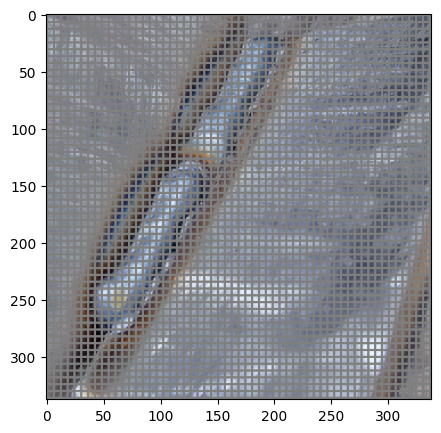

In [14]:
# Extract patches from the test images using the defined function
patches = extract_patches(test_images, patch_size=patch_size)

patches_square = patches.reshape(test_images.shape[0], -1, 3, patch_size, patch_size)

# Calculate the grid size for visualization
grid_size = test_images.shape[2] // patch_size
print("Sequence Length %d" % (grid_size**2))

# Visualize the patches as a grid
plt.figure(figsize=(5, 5))
out = torchvision.utils.make_grid(patches_square[0], grid_size, normalize=True, pad_value=0.5)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [15]:
# Transformer block with self-attention
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4):
        # Initialize the parent nn.Module
        super(TransformerBlock, self).__init__()
        
        # Layer normalization to normalize the input data
        self.norm1 = nn.LayerNorm(hidden_size)
        
        # Multi-head attention mechanism
        self.multihead_attn = nn.MultiheadAttention(hidden_size, num_heads=num_heads, 
                                                    batch_first=True, dropout=0.1)
        
        # Another layer normalization
        self.norm2 = nn.LayerNorm(hidden_size)
        
        # Multi-layer perceptron (MLP) with a hidden layer and activation function
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LayerNorm(hidden_size * 2),
            nn.ELU(),
            nn.Linear(hidden_size * 2, hidden_size)
        )
                
    def forward(self, x):
        # Apply the first layer normalization
        norm_x = self.norm1(x)
        
        # Apply multi-head attention and add the input (residual connection)
        x = self.multihead_attn(norm_x, norm_x, norm_x)[0] + x
        
        # Apply the second layer normalization
        norm_x = self.norm2(x)
        
        # Pass through the MLP and add the input (residual connection)
        x = self.mlp(norm_x) + x
        
        return x
    

class ViT(nn.Module):
    def __init__(self, image_size, channels_in, patch_size, hidden_size, num_layers, num_heads=8):
        # Call the __init__ function of the parent nn.Module class
        super(ViT, self).__init__()
        
        self.patch_size = patch_size
        
        # Fully connected layer to project input patches to the hidden size dimension
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        # Create a list of Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads) for _ in range(num_layers)
        ])
        
        # Fully connected output layer to map to the number of classes (e.g., 10 for CIFAR-10)
        self.fc_out = nn.Linear(hidden_size, 10)
        
        # Parameter for the output token
        self.out_vec = nn.Parameter(torch.zeros(1, 1, hidden_size))
        
        # Positional embeddings to retain positional information of patches
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.001))

    def forward(self, image):
        bs = image.shape[0]

        # Extract patches from the image and flatten them
        patch_seq = extract_patches(image, patch_size=self.patch_size)
        
        # Project patches to the hidden size dimension
        patch_emb = self.fc_in(patch_seq)

        # Add positional embeddings to the patch embeddings
        patch_emb = patch_emb + self.pos_embedding
        
        # Concatenate the output token to the patch embeddings
        embs = torch.cat((self.out_vec.expand(bs, 1, -1), patch_emb), 1)

        # Pass the embeddings through each Transformer block
        for block in self.blocks:
            embs = block(embs)
        
        # Use the embedding of the output token for classification
        return self.fc_out(embs[:, 0])

## Create our model and view the ouput!

In [16]:
# Create a dataloader itterable object
dataiter = next(iter(train_loader))
# Sample from the itterable object
train_images, train_labels = dataiter

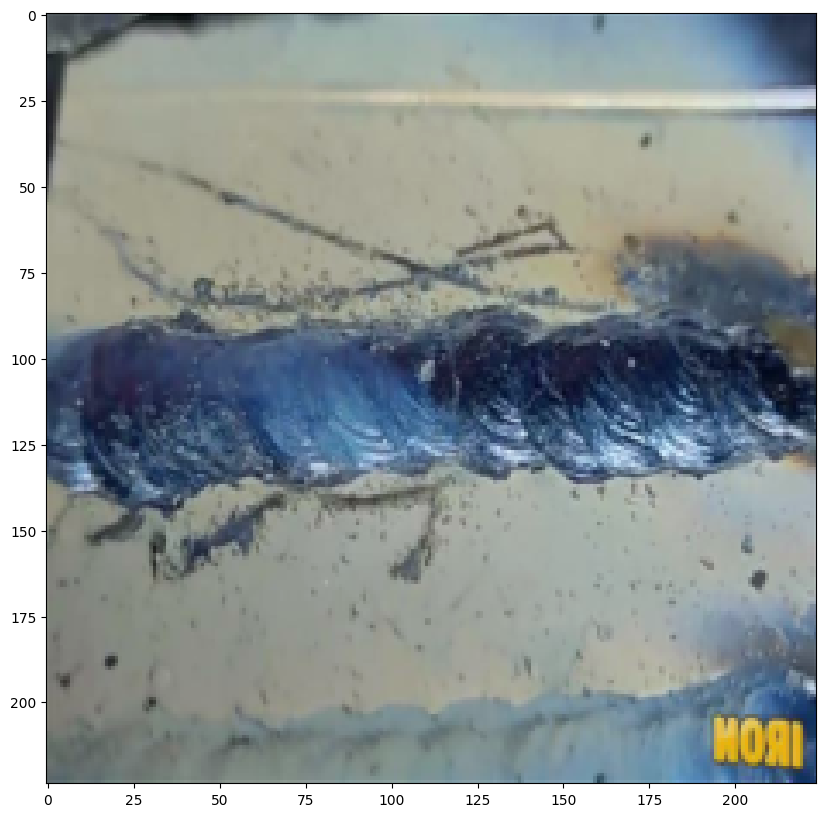

In [ ]:

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(train_images, 8, normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [18]:
# Create an instance of our network
# Set channels_in to the number of channels of the dataset images
model = ViT(image_size=test_images.shape[2], 
            channels_in=test_images.shape[1], 
            patch_size=patch_size, 
            hidden_size=64,
            num_layers=4,
            num_heads=4).to(device)

# View the network
# the layer order is simply the order in which we defined them, NOT the order of the forward pass
print(model)

ViT(
  (fc_in): Linear(in_features=48, out_features=64, bias=True)
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (2): ELU(alpha=1.0)
        (3): Linear(in_features=128, out_features=64, bias=True)
      )
    )
  )
  (fc_out): Linear(in_features=64, out_features=10, bias=True)
)


In [19]:
num_model_params = 0
for param in model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 339466 (Approximately 0 Million) Parameters!


In [20]:
# Pass image through network
out = model(test_images.to(device))
# Check output
out.shape

torch.Size([1, 10])

<h3> Set up the optimizer </h3>

In [21]:
# Pass our network parameters to the optimiser set our lr as the learning_rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                    T_max=num_epochs, 
                                                    eta_min=0)

In [22]:
# Define a Cross Entropy Loss
loss_fun = nn.CrossEntropyLoss()

# Define the training process

In [ ]:
# This function should perform a single training epoch using our training data
def train(model, optimizer, loader, device, loss_fun, loss_logger):
    
    # Set Network in train mode
    model.train()
    for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Training")):
        # Forward pass of image through network and get output
        fx = model(x.to(device))
        
        # Calculate loss using loss function
        loss = loss_fun(fx, y.to(device))

        # Zero Gradents
        optimizer.zero_grad()
        # Backpropagate Gradents
        loss.backward()
        # Do a single optimization step
        optimizer.step()
        
        # Log the loss for plotting
        loss_logger.append(loss.item())
        
    return model, optimizer, loss_logger

# Define the testing process

In [ ]:
# This function should perform a single evaluation epoch, it WILL NOT be used to train our model
def evaluate(model, device, loader):
    
    # Initialise counter
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(tqdm(loader, leave=False, desc="Evaluating")):
            # Forward pass of image through network
            fx = model(x.to(device))
            
            # Log the cumulative sum of the acc
            epoch_acc += (fx.argmax(1) == y.to(device)).sum().item()
            
    # Return the accuracy from the epoch     
    return epoch_acc / len(loader.dataset)

# The training process

In [25]:
training_loss_logger = []
validation_acc_logger = []
training_acc_logger = []

In [26]:
valid_acc = 0
train_acc = 0

# This cell implements our training loop
pbar = trange(0, num_epochs, leave=False, desc="Epoch")    
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))

    # Call the training function and pass training dataloader etc
    model, optimizer, training_loss_logger = train(model=model, 
                                                   optimizer=optimizer, 
                                                   loader=train_loader, 
                                                   device=device, 
                                                   loss_fun=loss_fun, 
                                                   loss_logger=training_loss_logger)

    # Call the evaluate function and pass the dataloader for both validation and training
    train_acc = evaluate(model=model, device=device, loader=train_loader)
    valid_acc = evaluate(model=model, device=device, loader=valid_loader)

    # Log the train and validation accuracies
    validation_acc_logger.append(valid_acc)
    training_acc_logger.append(train_acc)
    
    # Reduce learning rate
    lr_scheduler.step()

print("Training Complete")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/912 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/102 [00:00<?, ?it/s]

Training Complete


In [27]:
model_save_path = "C:/Users/Ju/Downloads/weld_vit_split/vit_weld_classifier.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to C:/Users/Ju/Downloads/weld_vit_split/vit_weld_classifier.pth


In [28]:
model_save_path = "C:/Users/Ju/Downloads/weld_vit_split/vit_weld_classifier_full.pth"
torch.save(model, model_save_path)
print(f"Model and weights saved to {model_save_path}")

Model and weights saved to C:/Users/Ju/Downloads/weld_vit_split/vit_weld_classifier_full.pth


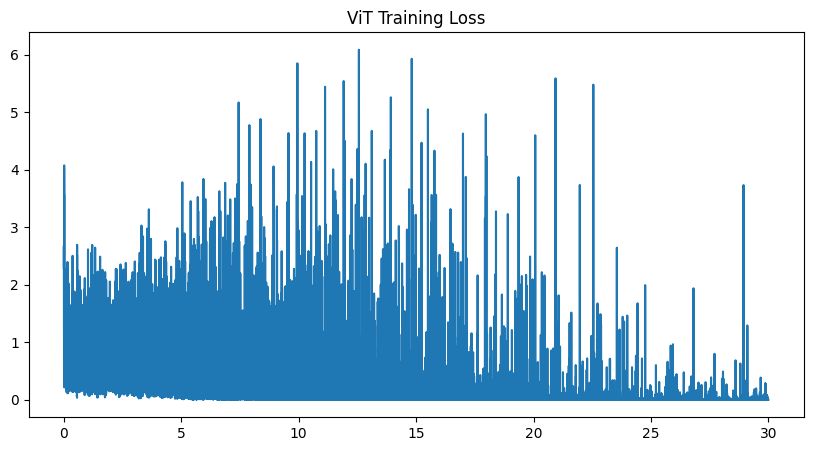

In [29]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_loss_logger))
plt.plot(train_x, training_loss_logger)
_ = plt.title("ViT Training Loss")

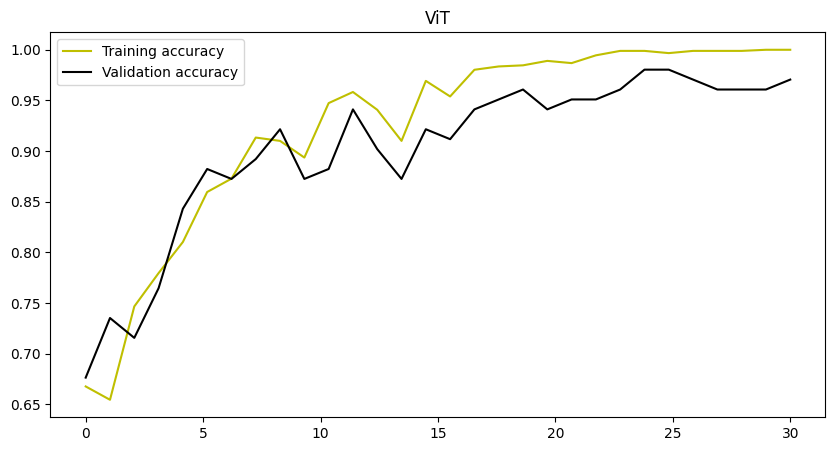

In [30]:
plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(training_acc_logger))
plt.plot(train_x, training_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(validation_acc_logger))
plt.plot(valid_x, validation_acc_logger, c = "k")

plt.title("ViT")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [31]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = evaluate(model=model, device=device, loader=test_loader)
print("The total test accuracy is: %.2f%%" %(test_acc*100))

Evaluating:   0%|          | 0/218 [00:00<?, ?it/s]

The total test accuracy is: 90.37%


Predicted Values
 [0]
True Values
 [0]


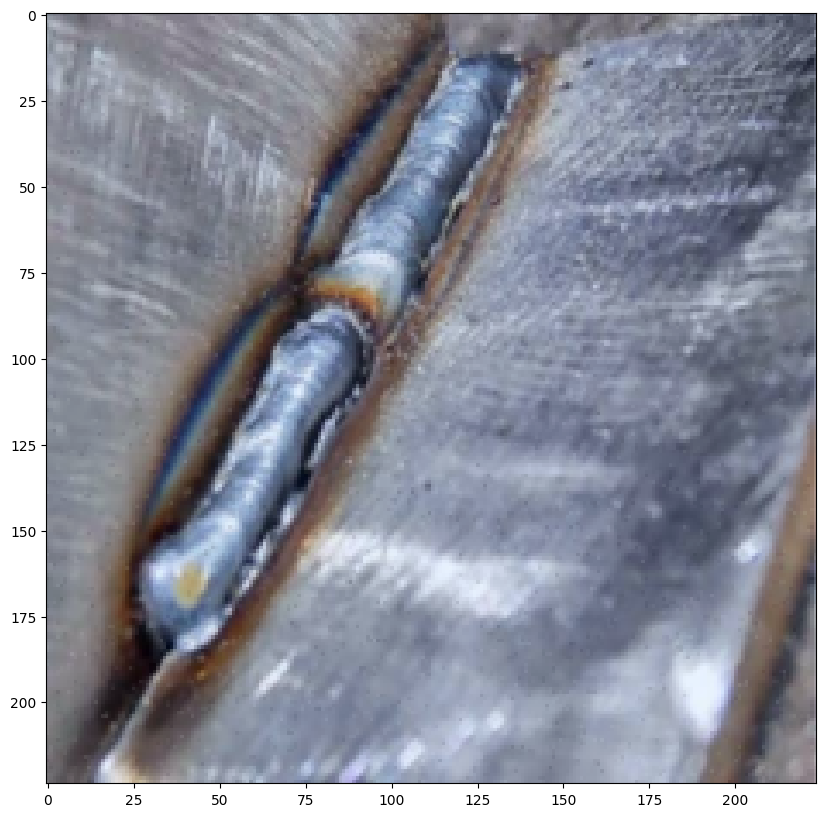

In [32]:
# Lets visualise the prediction for a few test images!
with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)
    
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))

print("Predicted Values\n", list(pred.cpu().numpy()))
print("True Values\n", list(test_labels[:8].numpy()))

Predicted Values:
['bad_welding']

True Values:
['bad_welding']


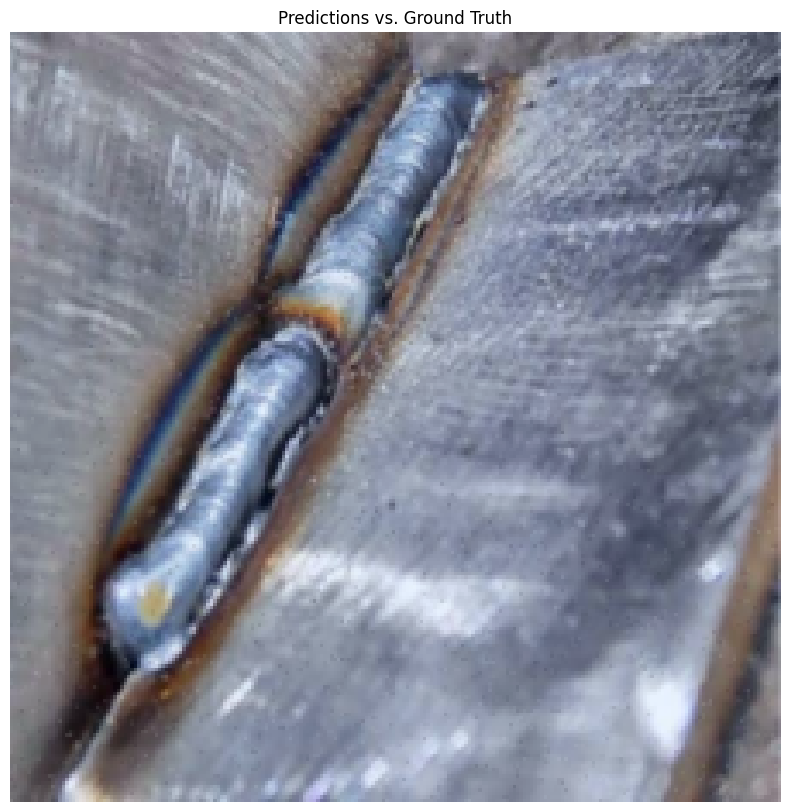

In [33]:
# Label mapping
class_names = ['bad_welding', 'good_welding']

# Get model predictions
with torch.no_grad():
    fx = model(test_images[:8].to(device))
    pred = fx.argmax(-1)

# Plot the images
plt.figure(figsize=(20, 10))
out = torchvision.utils.make_grid(test_images[:8], 8, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title("Predictions vs. Ground Truth")

# Print predictions and true values
print("Predicted Values:")
print([class_names[i] for i in pred.cpu().numpy()])

print("\nTrue Values:")
print([class_names[i] for i in test_labels[:8].numpy()])

Predicted:
['good_welding', 'good_welding', 'good_welding', 'good_welding', 'good_welding', 'good_welding', 'bad_welding', 'good_welding']

Ground Truth:
['bad_welding', 'good_welding', 'good_welding', 'good_welding', 'good_welding', 'good_welding', 'bad_welding', 'bad_welding']


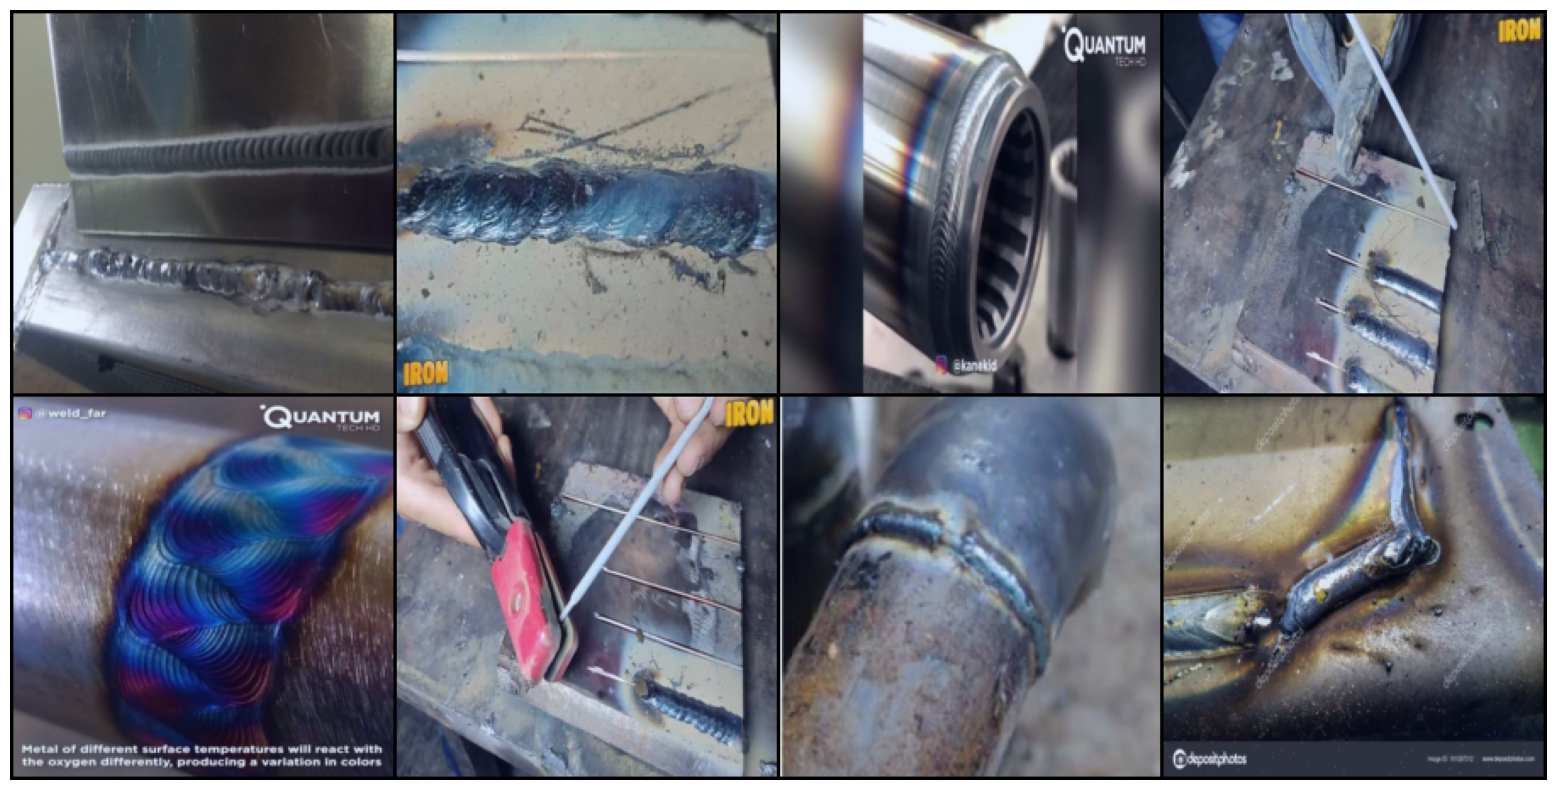

In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

# Class names (adjust if your class order is different)
class_names = ['bad_welding', 'good_welding']

# Create a DataLoader for test data (batch size 8 as example)
test_loader = DataLoader(test_data, batch_size=8, shuffle=True)

# Get a batch of test images
test_images, test_labels = next(iter(test_loader))

# Move to device
test_images = test_images.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(test_images)
    preds = outputs.argmax(dim=1)

# Move everything back to CPU for visualization
test_images = test_images.cpu()
preds = preds.cpu()
test_labels = test_labels.cpu()

# Plot the images with predicted and true labels
plt.figure(figsize=(20, 10))
grid_img = torchvision.utils.make_grid(test_images, nrow=4, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')

# Print predictions and ground truth
print("Predicted:")
print([class_names[i] for i in preds])
print("\nGround Truth:")
print([class_names[i] for i in test_labels])

DeIT Vision Transformer

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
import os

In [ ]:
batch_size = 8
num_epochs = 20
learning_rate = 1e-4

train_dir = "C:/Users/Ju/Downloads/weld_vit_split/train"
test_dir = "C:/Users/Ju/Downloads/weld_vit_split/test"
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [37]:
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    return model.to(device)

In [38]:
def train_model(model, model_name):
    print(f"\nTraining {model_name}...\n")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {train_acc:.2f}%")

    print(f"\nFinished Training {model_name}\n")
    return model

In [39]:
def evaluate_model(model):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

In [40]:
deit_model = get_model("deit_base_patch16_224")
deit_model = train_model(deit_model, "DeiT")
evaluate_model(deit_model)



Training DeiT...



Epoch 1/20: 100%|██████████| 127/127 [01:10<00:00,  1.80it/s]


Epoch [1/20], Loss: 22.5250, Accuracy: 93.10%


Epoch 2/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [2/20], Loss: 5.9676, Accuracy: 98.42%


Epoch 3/20: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s]


Epoch [3/20], Loss: 0.1904, Accuracy: 99.90%


Epoch 4/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [4/20], Loss: 0.0271, Accuracy: 100.00%


Epoch 5/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [5/20], Loss: 0.0164, Accuracy: 100.00%


Epoch 6/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [6/20], Loss: 0.0119, Accuracy: 100.00%


Epoch 7/20: 100%|██████████| 127/127 [01:12<00:00,  1.76it/s]


Epoch [7/20], Loss: 0.0091, Accuracy: 100.00%


Epoch 8/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [8/20], Loss: 0.0072, Accuracy: 100.00%


Epoch 9/20: 100%|██████████| 127/127 [01:11<00:00,  1.76it/s]


Epoch [9/20], Loss: 0.0059, Accuracy: 100.00%


Epoch 10/20: 100%|██████████| 127/127 [01:12<00:00,  1.76it/s]


Epoch [10/20], Loss: 0.0049, Accuracy: 100.00%


Epoch 11/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [11/20], Loss: 0.0041, Accuracy: 100.00%


Epoch 12/20: 100%|██████████| 127/127 [01:12<00:00,  1.76it/s]


Epoch [12/20], Loss: 0.0035, Accuracy: 100.00%


Epoch 13/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [13/20], Loss: 0.0030, Accuracy: 100.00%


Epoch 14/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [14/20], Loss: 0.0026, Accuracy: 100.00%


Epoch 15/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [15/20], Loss: 0.0023, Accuracy: 100.00%


Epoch 16/20: 100%|██████████| 127/127 [01:11<00:00,  1.78it/s]


Epoch [16/20], Loss: 0.0020, Accuracy: 100.00%


Epoch 17/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [17/20], Loss: 0.0018, Accuracy: 100.00%


Epoch 18/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [18/20], Loss: 0.0016, Accuracy: 100.00%


Epoch 19/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [19/20], Loss: 0.0014, Accuracy: 100.00%


Epoch 20/20: 100%|██████████| 127/127 [01:11<00:00,  1.77it/s]


Epoch [20/20], Loss: 0.0012, Accuracy: 100.00%

Finished Training DeiT

Test Accuracy: 95.41%


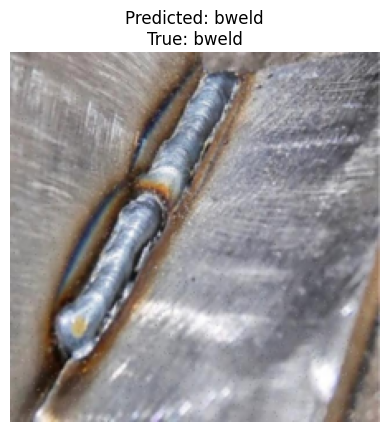

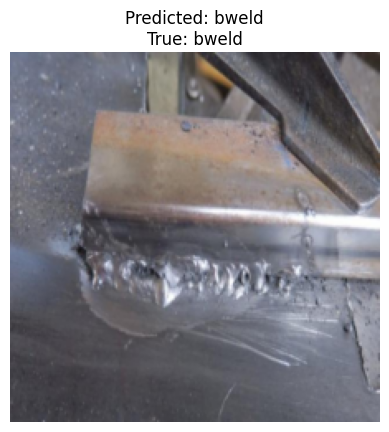

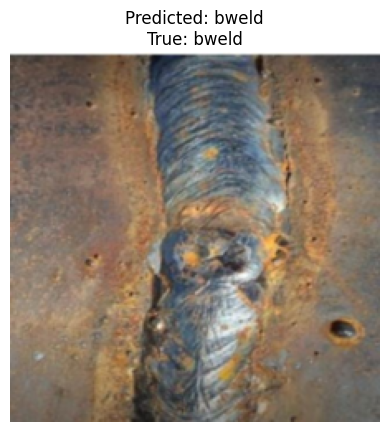

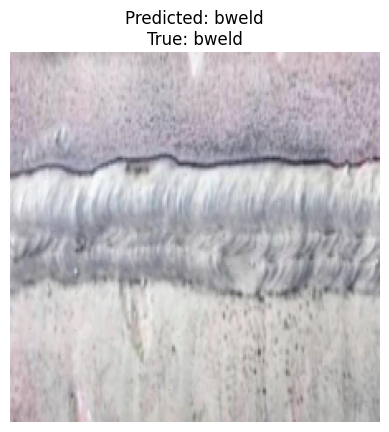

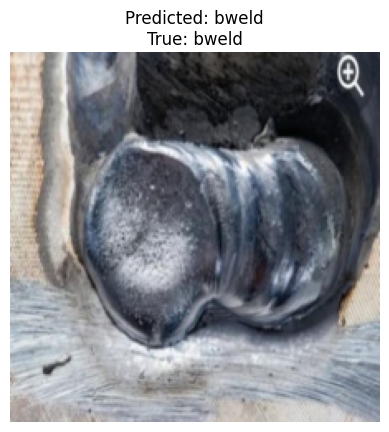

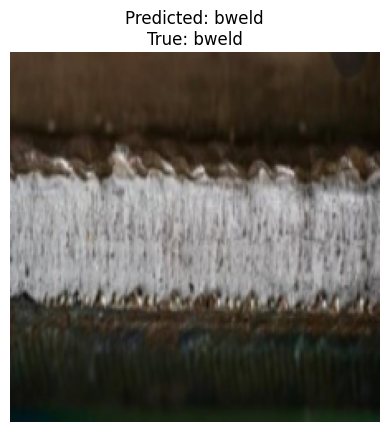

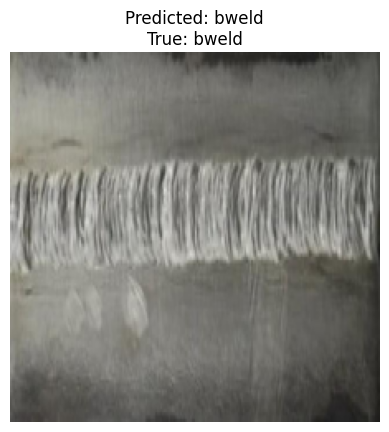

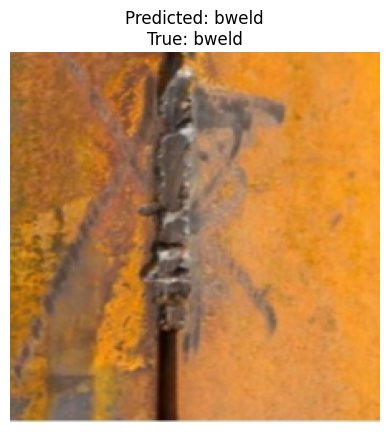

In [41]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os

# ----------------------------------------------
# Class labels from dataset
# ----------------------------------------------
class_names = train_dataset.classes  # This gives class names in correct index order

# ----------------------------------------------
# Function to display predictions on test samples
# ----------------------------------------------
def show_predictions(model, loader, num_images=8):
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Move to CPU for visualization
            inputs = inputs.cpu()
            preds = preds.cpu()
            labels = labels.cpu()

            for i in range(inputs.size(0)):
                img = inputs[i].permute(1, 2, 0).numpy()
                img = (img * 0.5) + 0.5  # Unnormalize
                img = np.clip(img, 0, 1)

                plt.imshow(img)
                plt.title(f"Predicted: {class_names[preds[i]]}\nTrue: {class_names[labels[i]]}")
                plt.axis('off')
                plt.show()

                images_shown += 1
                if images_shown >= num_images:
                    return

# ----------------------------------------------
# Call this after training
# ----------------------------------------------
show_predictions(deit_model, test_loader, num_images=8)

In [42]:
# Save the trained DeiT model
deit_save_path = "deit_model.pth"
torch.save(deit_model.state_dict(), deit_save_path)
print(f"Model saved to: {deit_save_path}")


Model saved to: deit_model.pth
